# Libraries Import
## Regular Libraries

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col=0, parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col=0, parse_dates=['time'])

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 11.94 Mb (69.3% reduction)
Mem. usage decreased to  0.03 Mb (68.2% reduction)


In [5]:
from datetime import datetime
from math import sin, cos, pi


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt

In [6]:
# Memorial Day
train = train[(train.time.dt.month != 5) | (train.time.dt.day != 27)]

# July 4
train = train[(train.time.dt.month != 7) | (train.time.dt.day != 4)]

# Labor Day
train = train[(train.time.dt.month != 9) | (train.time.dt.day != 2)]

In [7]:
def fe0(data):
    data['weekday'] = data.time.dt.weekday
    data['hour'] = data.time.dt.hour
    data['timeofday'] = data.time.dt.time

    data['saturday'] = data['weekday'] == 5
    data['sunday'] = data['weekday'] == 6
    data['minute'] = data.time.dt.minute
    data = data.drop(columns='time')
    return data

In [8]:
train = fe0(train)
test = fe0(test)

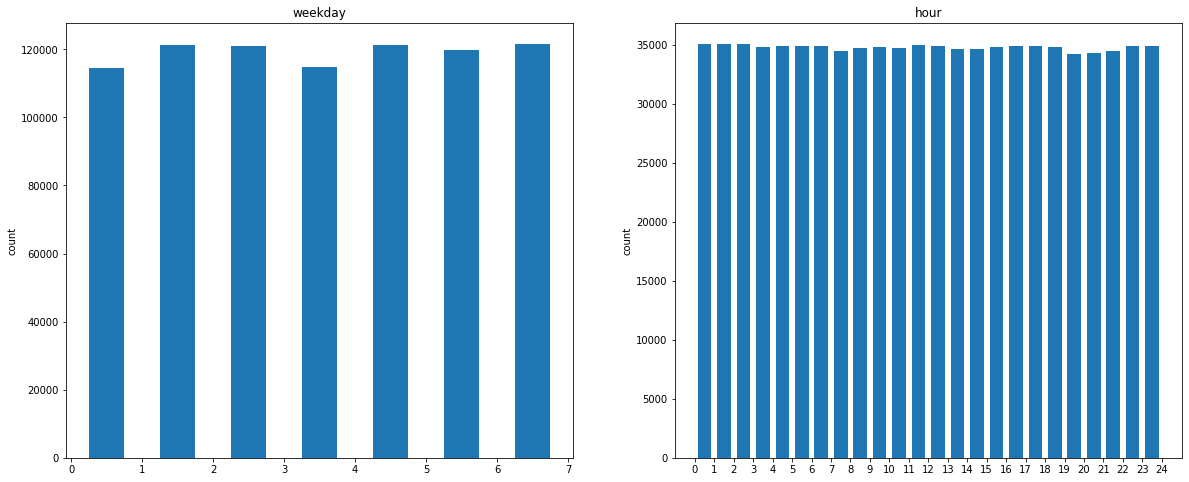

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
bin_weekday = list(range(8))
axs[0].hist(train.weekday, bin_weekday, rwidth=0.5)
axs[0].set_title('weekday')
axs[0].set_xticks(bin_weekday)
axs[0].set_ylabel('count')

bin_hour = list(range(25))
axs[1].hist(train.hour, bin_hour, rwidth=0.7)
axs[1].set_title('hour')
axs[1].set_xticks(bin_hour)
axs[1].set_ylabel('count')

plt.show()

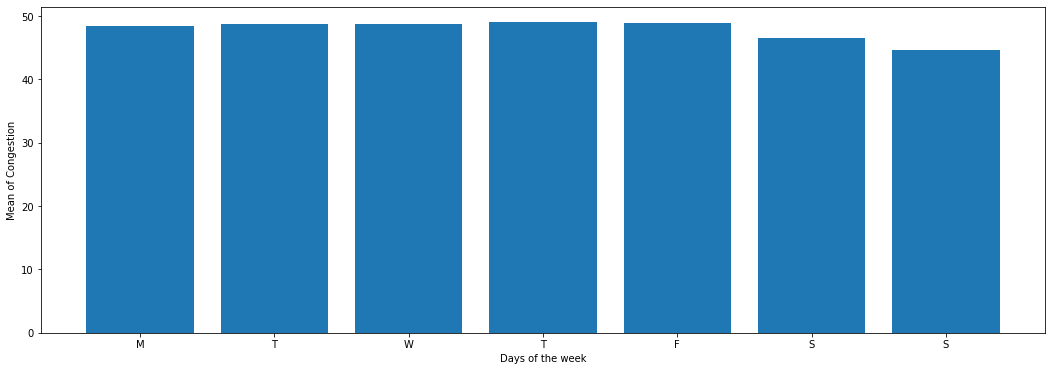

In [10]:
temp = train.groupby(train.weekday).congestion.mean()
plt.figure(figsize=(18, 6))
plt.bar(temp.index, temp)
plt.xticks(ticks=temp.index, labels='MTWTFSS')
plt.xlabel('Days of the week')
plt.ylabel('Mean of Congestion')
plt.show()

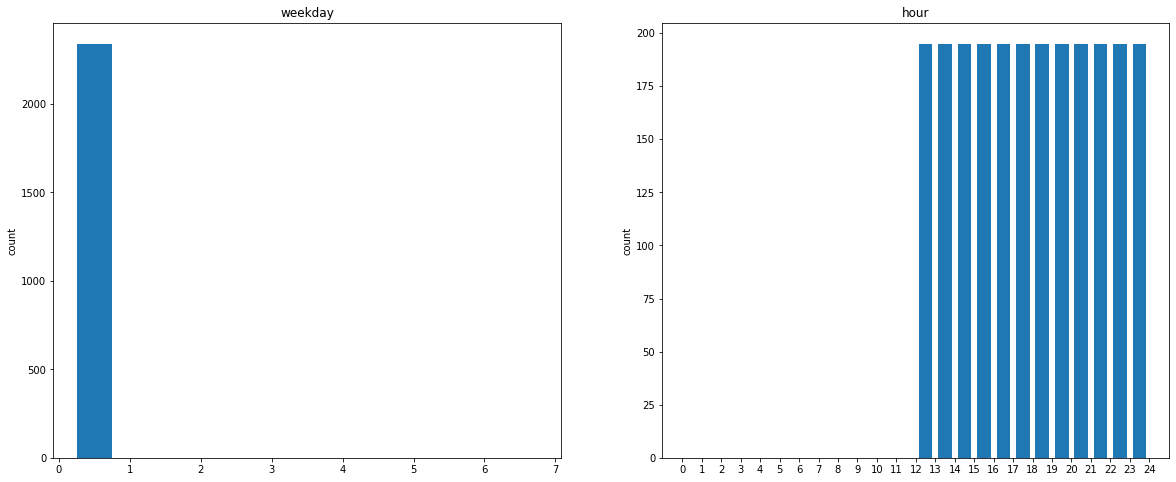

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
bin_weekday = list(range(8))
axs[0].hist(test.weekday, bin_weekday, rwidth=0.5)
axs[0].set_title('weekday')
axs[0].set_xticks(bin_weekday)
axs[0].set_ylabel('count')

bin_hour = list(range(25))
axs[1].hist(test.hour, bin_hour, rwidth=0.7)
axs[1].set_title('hour')
axs[1].set_xticks(bin_hour)
axs[1].set_ylabel('count')

plt.show()